# 2: Image Quilting

In [437]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random, randint
import time

datadir = "/Users/marchon/Downloads/proj2_quilting/"
utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

In [438]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture

In [161]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    # Determine the number of patches needed along each dimension 
    patches_cnt = out_size // patch_size
    
    # Initialize an empty array for the output image
    output_image = np.zeros((out_size, out_size, sample.shape[2]), dtype=sample.dtype)
    
    for i in range(patches_cnt):
        for j in range(patches_cnt):
            # Randomly select the upper-left pixel of a patch in the sample image
            x = randint(0, sample.shape[1] - patch_size) # Width
            y = randint(0, sample.shape[0] - patch_size) # Height
            
            # Extract the patch from the sample image
            patch = sample[y:y + patch_size, x:x + patch_size]
            
            # Place the patch into the output image
            output_image[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size] = patch

    return output_image
    



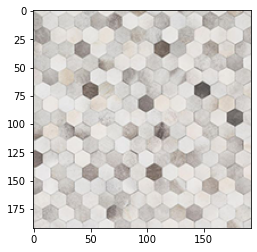

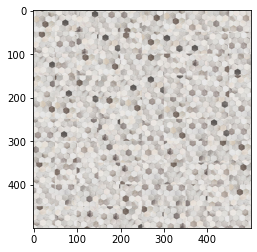

In [163]:
sample_img_fn = samplesfn + '/pattern_0.png'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 500  # change these parameters as needed
patch_size = 50
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches 

In [158]:
def ssd_patch(image, template, mask):
    """
    performs template matching with the overlapping region, computing the cost of sampling each patch, 
    based on the sum of squared differences (SSD) of the overlapping regions of the existing and sampled patch. 
    
    :param template: numpy.ndarray, the patch in the current output image that is to be filled in
    :param mask: numpy.ndarray, the mask has the same size as the patch template and has 
    values of 1 in the overlapping region and values of 0 elsewhere.
    :param image: numpy.ndarray
    :return: numpy.ndarray
    """
    
    # Convert to floating point
    template, image = template.astype(np.float32), image.astype(np.float32)
    
    # Initiate ssd_cost (floating point)
    ssd_cost = np.zeros(image.shape[:2], dtype=np.float32)
    
    # Compute ssd for each channel
    for i in range(image.shape[2]):
        image_channel = image[:, :, i]
        template_channel = template[:, :, i]
        channel_cost = ((mask * template_channel) ** 2).sum() - 2 * \
        cv2.filter2D(image_channel, ddepth=-1, kernel=mask*template_channel) + \
        cv2.filter2D(image_channel ** 2, ddepth=-1, kernel=mask)
        ssd_cost += channel_cost
    
    # copies a patch from (in_r, in_c) to (out_r, out_c)
    br = template.shape[0] // 2
    maxval = ssd_cost.max() 
    ssd_cost[:br, :] = maxval 
    ssd_cost[:, :br] = maxval
    ssd_cost[-br:, :] = maxval
    ssd_cost[:, -br:] = maxval
    
    return ssd_cost

def choose_sample(cost_image, tol):
    """
    :param cost_image: numpy.ndarray
    :tol: int
    :return: numpy.ndarray
    """

    # Convert 2d array to 1d array and get the sorted idx array
    sorted_idx_arr = np.argsort(cost_image.flatten()) 
    
    # Get the idx with one of the lowest costs
    sample_idx = sorted_idx_arr[(int)(random() * tol)]

    # Get 2D indices from 1D index
    in_r, in_c = np.unravel_index(sample_idx, cost_image.shape)
 
    return in_r, in_c

def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to 
    create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    
    # Initialize an empty array for the output image
    output_image = np.zeros((out_size, out_size, sample.shape[2]), dtype=sample.dtype)
    patch_ctr = patch_size // 2
    
    for i in range(0, out_size - patch_size + 1, patch_size - overlap):
        for j in range(0, out_size - patch_size + 1, patch_size - overlap):
            # Edge condition
            if i == 0 and j == 0:
                # Random selection
                in_r, in_c = (int)(random() * (sample.shape[0] - patch_size)), \
                (int)(random() * (sample.shape[1] - patch_size))
                patch = sample[in_r:in_r + patch_size, in_c:in_c + patch_size]

            else:    
                # Patch to fill the current output image    
                template = output_image[i:i+patch_size, j:j+patch_size]
                
                # Mask has the same size wth template and has value of 1 in the overlapping region
                mask = np.zeros(template.shape[:2])

                # Mask's overelapping condition
                if i != 0:
                    mask[:overlap, :] = 1
                if j != 0:
                    mask[:, :overlap] = 1
                
                # Each pixel's value is the cost of selecting the patch centered at that pixel
                cost_image = ssd_patch(sample, template, mask)
                
                in_r, in_c = choose_sample(cost_image, tol)
                
                # Extract the patch from the sample image
                if patch_size % 2 == 1:
                    patch = sample[in_r - patch_ctr : in_r + patch_ctr + 1, \
                                   in_c - patch_ctr : in_c + patch_ctr + 1]
                else:
                    patch = sample[in_r - patch_ctr : in_r + patch_ctr, \
                                   in_c - patch_ctr : in_c + patch_ctr]
            
            # Place the patch into the output image        
            output_image[i:i+patch_size, j:j+patch_size] = patch
                
    return output_image


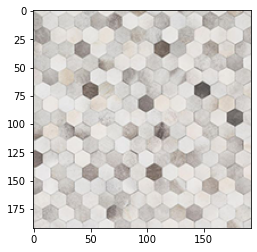

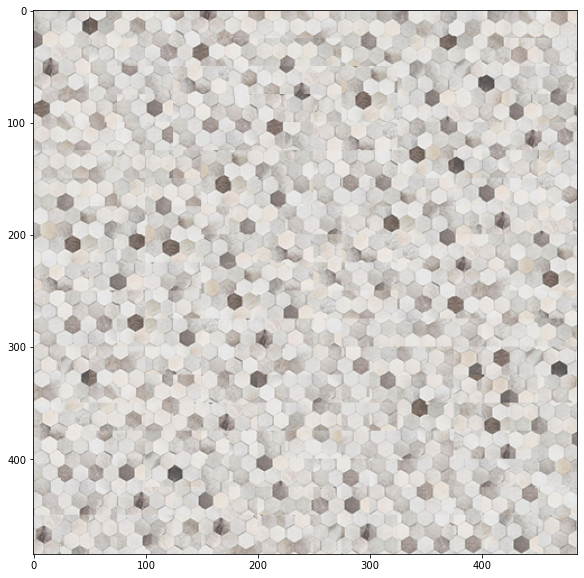

In [168]:
sample_img_fn = 'samples/pattern_0.png'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 485  # change these parameters as needed
patch_size = 35 # use an odd number so its center is well-defined
overlap = 10
tol = 5
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)

### Part III: Seam Finding


In [275]:
def customized_cut(bndcost):
    pass

In [364]:
def get_cost(p1, p2):
    # Calcualte square diff
    return np.sum((p1 - p2)**2, axis=2)

def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    
    # Initialize an empty array for the output image
    output_image = np.zeros((out_size, out_size, sample.shape[2]), dtype=sample.dtype)
    patch_ctr = patch_size // 2
 
    for i in range(0, out_size - patch_size + 1, patch_size - overlap):
        for j in range(0, out_size - patch_size + 1, patch_size - overlap):
            # Edge condition
            if i == 0 and j == 0:
                # Random selection
                in_r, in_c = (int)(random() * (sample.shape[0] - patch_size)), \
                (int)(random() * (sample.shape[1] - patch_size))
                patch = sample[in_r:in_r + patch_size, in_c:in_c + patch_size]
                output_image[:patch_size, :patch_size] = patch

            else:    
                # Patch to fill the current output image    
                template = output_image[i:i+patch_size, j:j+patch_size]

                # Mask has the same size wth template and has value of 1 in the overlapping region
                mask_temp = np.zeros(template.shape[:2])

                # Mask's overelapping condition
                if i != 0:
                    mask_temp[:overlap, :] = 1
                if j != 0:
                    mask_temp[:, :overlap] = 1

                # Each pixel's value is the cost of selecting the patch centered at that pixel
                cost_image = ssd_patch(sample, template, mask_temp)
                
                in_r, in_c = choose_sample(cost_image, tol)

                # Extract the patch from the sample image
                if patch_size % 2 == 1:
                    patch = sample[in_r - patch_ctr : in_r + patch_ctr + 1, \
                                   in_c - patch_ctr : in_c + patch_ctr + 1]
                else:
                    patch = sample[in_r - patch_ctr : in_r + patch_ctr, \
                                   in_c - patch_ctr : in_c + patch_ctr]
                
                # mask_seam, patch_seam have the same shape with template
                mask_seam, patch_seam = np.ones(template.shape[:2]), np.zeros_like(template)
                
                if i != 0:
                    # Square differences of the output image and the newly sampled patch
                    top_cost = get_cost(patch[:overlap, :], template[:overlap, :])
                    top_mask = cut(top_cost)
                    mask_seam[:overlap, :patch_size] = np.logical_and(top_mask,\
                                                                      mask_seam[:overlap, :patch_size])
                    
                if j != 0:
                    left_cost = get_cost(patch[:, :overlap], template[:, :overlap])
                    # Cut to the transposed patch
                    left_mask = cut(left_cost.T).T
                    mask_seam[:patch_size, :overlap] = np.logical_and(left_mask,\
                                                                      mask_seam[:patch_size, :overlap])
                  
                # Plot
                if i == (patch_size - overlap) * 8 and j == (patch_size - overlap) * 8:                    
                    plt.imshow(output_image)
                    plt.show()
                
                    plt.imshow(template)
                    plt.title("(a) the patch to be filled") 
                    plt.show()
                    
                    plt.imshow(top_cost)
                    plt.title("(b) horizontal cost") 
                    plt.show()
                    
                    plt.imshow(left_cost)
                    plt.title("(b) vertical cost") 
                    plt.show()
  
                    plt.imshow(top_mask)
                    plt.title("(c) horizontal mask")
                    plt.show()

                    plt.imshow(left_mask)
                    plt.title("(d) vertical mask")
                    plt.show()
                    
                    plt.imshow(mask_seam)
                    plt.title("(e) combination mask")
                    plt.show()
                    
                    plt.imshow((template * np.logical_not(mask_seam)[:, :, np.newaxis]) / 255.0)
                    plt.show()
                
                # Copy from template to patch_seam
                # Non-overlap 
                patch_seam[mask_seam == 0] = template[mask_seam == 0]

                # Overlap
                patch_seam[mask_seam == 1] = patch[mask_seam == 1]
                
                # Place the patch into the output image        
                output_image[i:i + patch_size, j:j + patch_size] = patch_seam
                
    return output_image

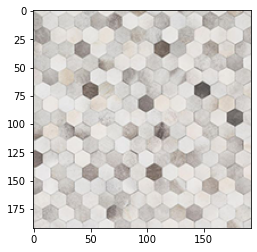

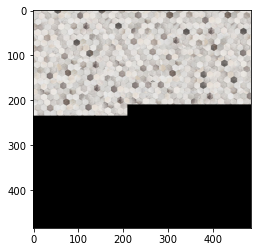

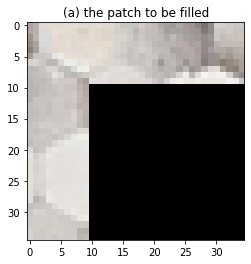

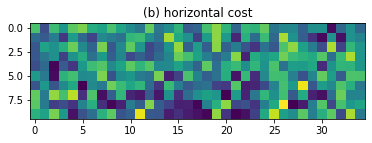

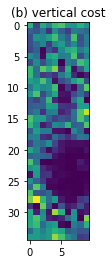

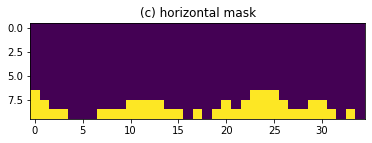

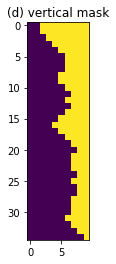

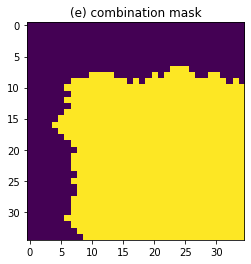

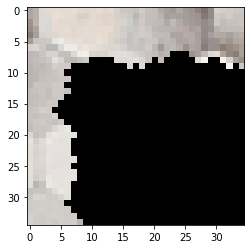

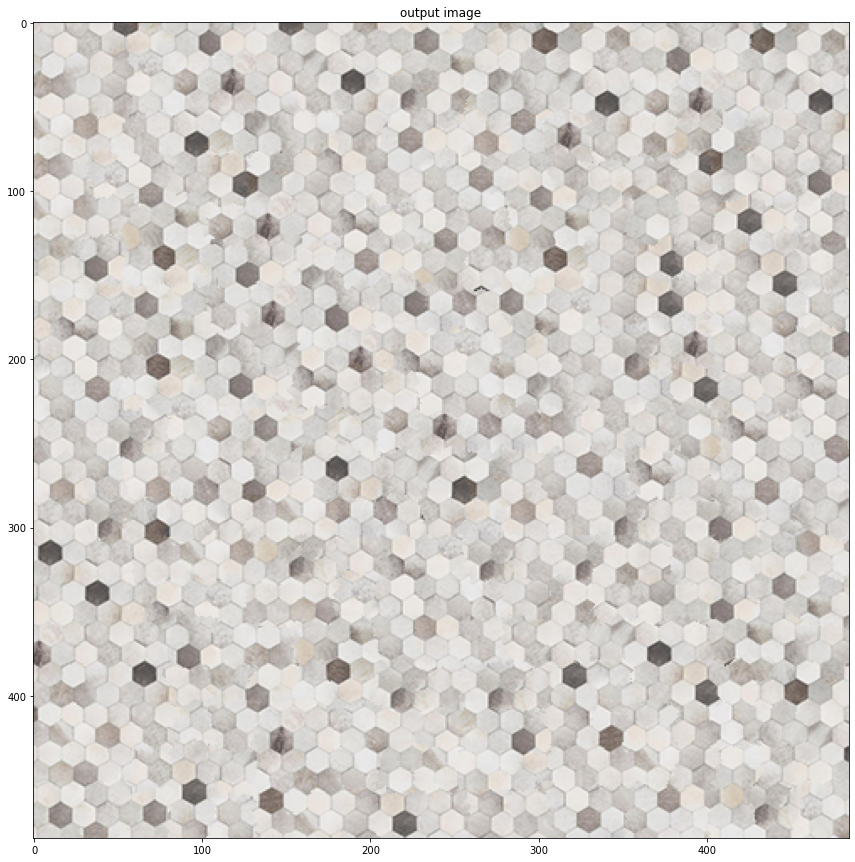

In [365]:
sample_img_fn = 'samples/pattern_0.png'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 485  # change these parameters as needed
patch_size = 35
overlap = 10
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(15,15))
    plt.title("output image")
    plt.imshow(res)



### Additional Quilting Results

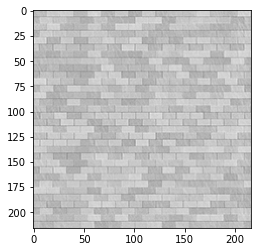

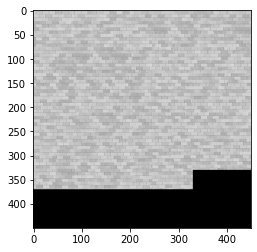

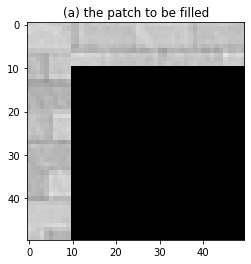

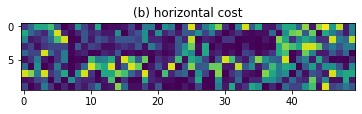

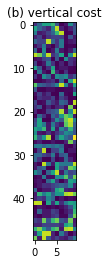

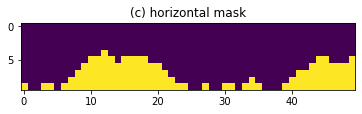

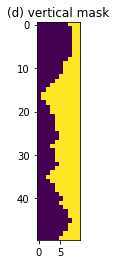

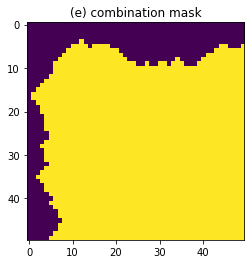

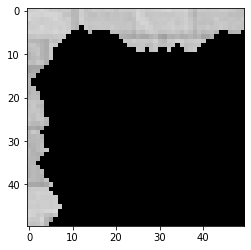

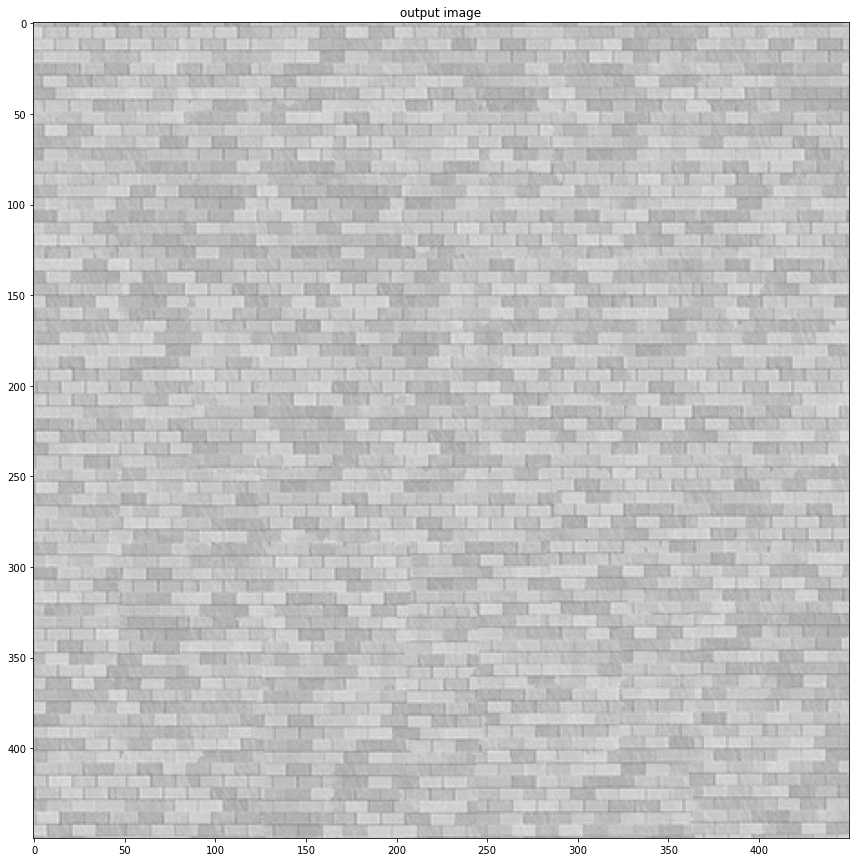

In [355]:
sample_img_fn = 'samples/paving.png'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 450 
patch_size = 50
overlap = 10
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(15,15))
    plt.title("output image")
    plt.imshow(res)

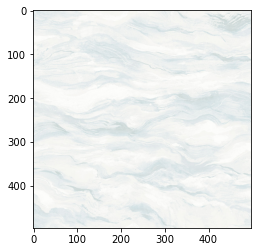

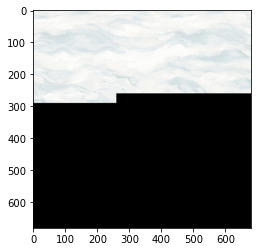

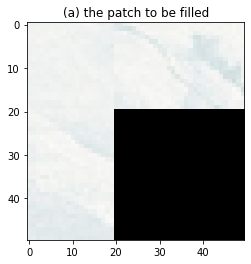

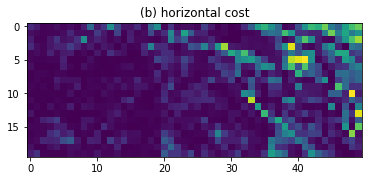

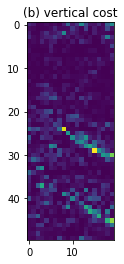

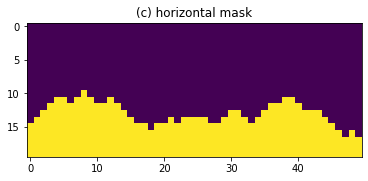

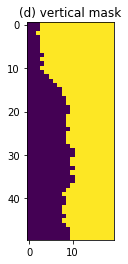

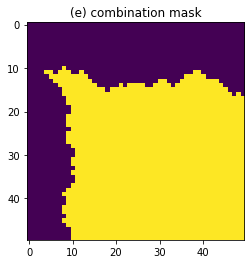

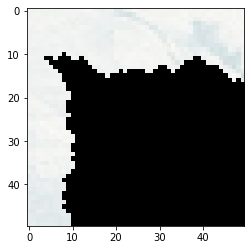

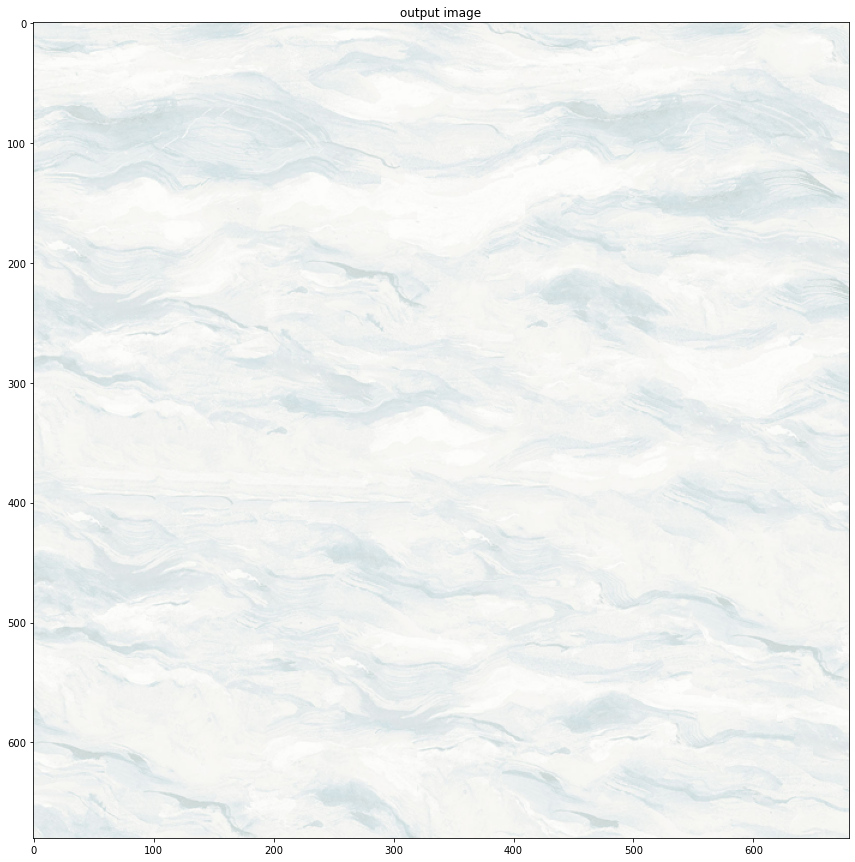

In [361]:
sample_img_fn = 'samples/pattern.png'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 680
patch_size = 50
overlap = 20
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(15,15))
    plt.title("output image")
    plt.imshow(res)

### part IV: Texture Transfer

In [407]:
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    
    # Initialize an empty array for the output image
    
    output_image = np.zeros_like(guidance_im)
    patch_ctr = patch_size // 2
    
    for i in range(0, output_image.shape[0] - patch_size + 1, patch_size - overlap):
        for j in range(0, output_image.shape[1] - patch_size + 1, patch_size - overlap):
            # Edge condition
            if i == 0 and j == 0:
                # Random selection
                in_r, in_c = (int)(random() * (sample.shape[0] - patch_size)), \
                (int)(random() * (sample.shape[1] - patch_size))
                patch = sample[in_r:in_r + patch_size, in_c:in_c + patch_size]
                output_image[:patch_size, :patch_size] = patch
                
            else:    
                # Patch to fill the current output image    
                template = output_image[i:i+patch_size, j:j+patch_size]
                
                # Patch for the guidance image
                guidance_template = guidance_im[i:i+patch_size, j:j+patch_size]

                # Mask has the same size wth template and has value of 1 in the overlapping region
                mask_temp = np.zeros(template.shape[:2])
                
                # Mask for the guidance image
                mask_guidance = np.ones((template.shape[:2]))
                
                # Mask's overelapping condition
                if i != 0:
                    mask_temp[:overlap, :] = 1
                if j != 0:
                    mask_temp[:, :overlap] = 1

                # Each pixel's value is the cost of selecting the patch centered at that pixel
                cost_image = ssd_patch(sample, template, mask_temp)
                cost_guidance = ssd_patch(sample, guidance_template, mask_guidance)
                
                # Algorithm from the paper
                cost_combined = alpha * cost_image.astype(np.float32) \
                + (1 - alpha) * cost_guidance.astype(np.float32)
                 
                in_r, in_c = choose_sample(cost_combined, tol)

                # Extract the patch from the sample image
                if patch_size % 2 == 1:
                    patch = sample[in_r - patch_ctr : in_r + patch_ctr + 1, \
                                   in_c - patch_ctr : in_c + patch_ctr + 1]
                else:
                    patch = sample[in_r - patch_ctr : in_r + patch_ctr, \
                                   in_c - patch_ctr : in_c + patch_ctr]
                
                # mask_seam, patch_seam have the same shape with template
                mask_seam, patch_seam = np.ones(template.shape[:2]), np.zeros_like(template)
                
                if i != 0:
                    # Square differences of the output image and the newly sampled patch
                    top_cost = get_cost(patch[:overlap, :], template[:overlap, :])
                    top_mask = cut(top_cost)
                    mask_seam[:overlap, :patch_size] = np.logical_and(top_mask,\
                                                                      mask_seam[:overlap, :patch_size])
                if j != 0:
                    left_cost = get_cost(patch[:, :overlap], template[:, :overlap])
                    # Cut to the transposed patch
                    left_mask = cut(left_cost.T).T
                    mask_seam[:patch_size, :overlap] = np.logical_and(left_mask,\
                                                                      mask_seam[:patch_size, :overlap])

                # Copy from template to patch_seam
                # Non-overlap 
                patch_seam[mask_seam == 0] = template[mask_seam == 0]

                # Overlap
                patch_seam[mask_seam == 1] = patch[mask_seam == 1]
                
                # Place the patch into the output image        
                output_image[i:i + patch_size, j:j + patch_size] = patch_seam
        
    return output_image

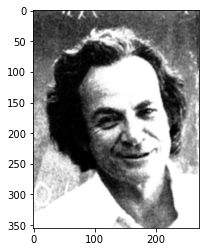

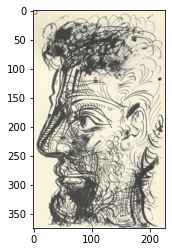

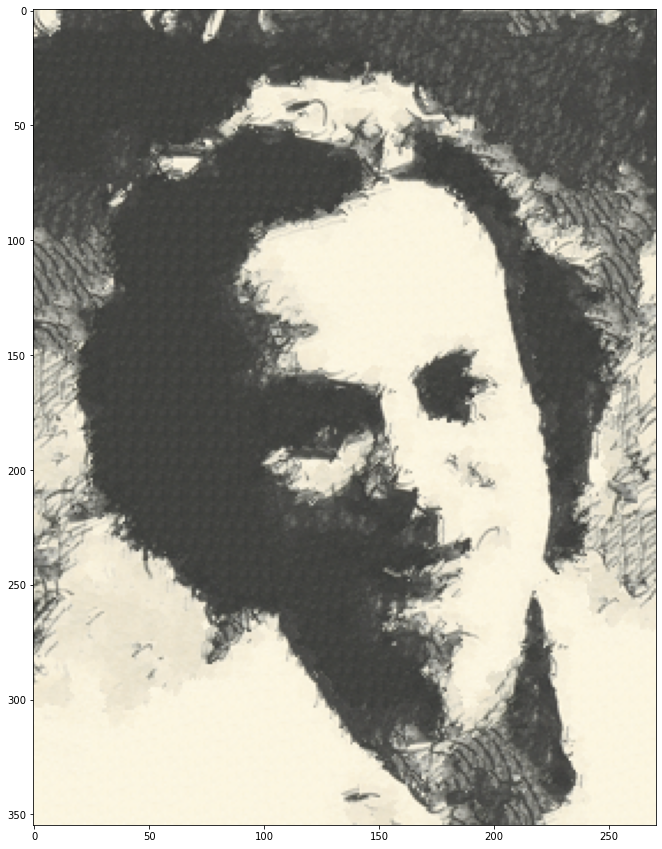

In [417]:
# load/process appropriate input texture and guidance images
sample_img_fn = 'samples/sketch.tiff' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
guidance_img_fn = 'samples/feynman.tiff' 
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(guidance_img)
plt.show()
plt.imshow(sample_img)
plt.show()

patch_size = 12
overlap = 5
tol = 3
alpha = 0.5

res = texture_transfer(sample_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(15,15))
plt.imshow(res)
plt.show()

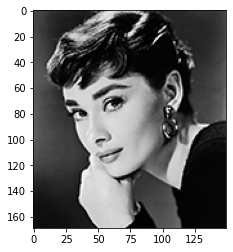

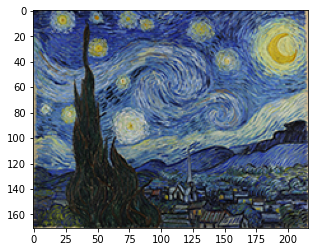

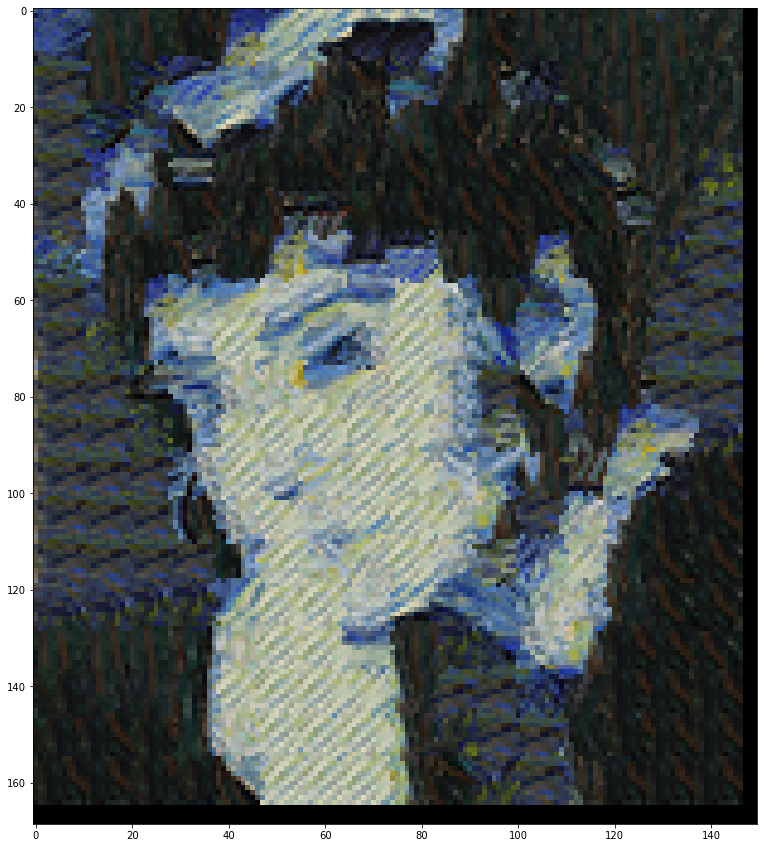

In [489]:
# load/process appropriate input texture and guidance images
sample_img_fn = '/samples/star.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
guidance_img_fn = '/samples/hepburn.jpg' 
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(guidance_img)
plt.show()
plt.imshow(sample_img)
plt.show()

patch_size = 12
overlap = 3
tol = 3
alpha = 0.3

res = texture_transfer(sample_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(15,15))
plt.imshow(res)
plt.show()